In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("walmart-sales-dataset-of-45stores.csv")

### Data Cleaning

In [3]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [4]:
df['Date']= pd.to_datetime(df['Date'], format="%d-%m-%Y")

df['WW'] =df['Date'].dt.isocalendar().week
df['Year'] =df['Date'].dt.isocalendar().year

### Moving Average

In [5]:
df_1 = df[['WW','Year', 'Weekly_Sales']]

In [6]:
aggregated_data = df_1.groupby(['Year', 'WW']).agg(
    total_weekly_sales=('Weekly_Sales', 'sum')
).reset_index()


In [7]:
aggregated_data['moving_avg_2'] =aggregated_data['total_weekly_sales'].rolling(window=2).mean()
aggregated_data['moving_avg_6'] =aggregated_data['total_weekly_sales'].rolling(window=4).mean()
aggregated_data['moving_avg_12'] =aggregated_data['total_weekly_sales'].rolling(window=6).mean()
aggregated_data['moving_avg_18'] =aggregated_data['total_weekly_sales'].rolling(window=8).mean()

In [8]:
import matplotlib.pyplot as plt
import math

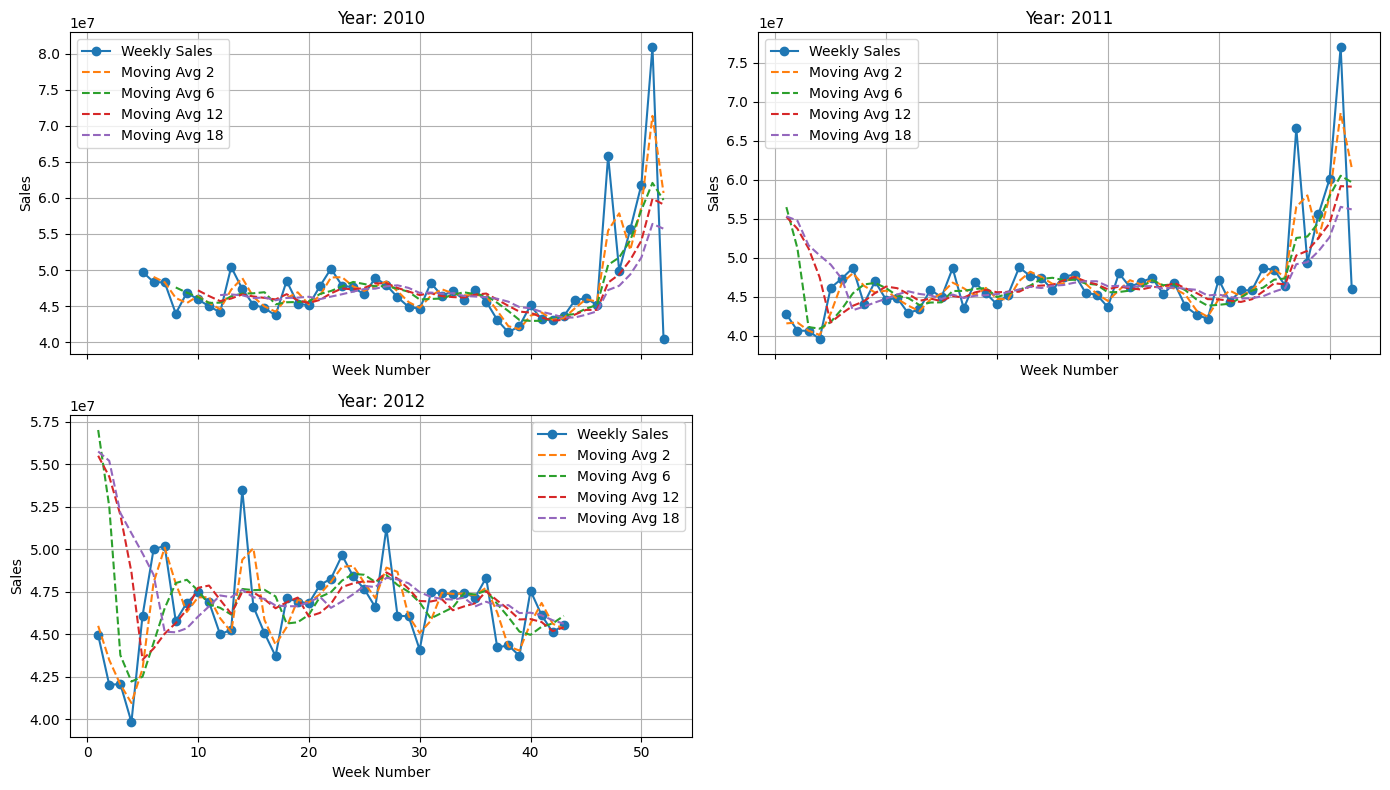

In [9]:
years = sorted(aggregated_data['Year'].unique())

# Get unique years

n_years = len(years)

# Define grid size (e.g., 2x2, 3x2, etc.)
n_cols = 2
n_rows = math.ceil(n_years / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each year and plot
for i, year in enumerate(years):
    ax = axes[i]
    yearly_data = aggregated_data[aggregated_data['Year'] == year]

    ax.plot(yearly_data['WW'], yearly_data['total_weekly_sales'], label='Weekly Sales', marker='o')
    ax.plot(yearly_data['WW'], yearly_data['moving_avg_2'], label='Moving Avg 2', linestyle='--')
    ax.plot(yearly_data['WW'], yearly_data['moving_avg_6'], label='Moving Avg 6', linestyle='--')
    ax.plot(yearly_data['WW'], yearly_data['moving_avg_12'], label='Moving Avg 12', linestyle='--')
    ax.plot(yearly_data['WW'], yearly_data['moving_avg_18'], label='Moving Avg 18', linestyle='--')
    ax.set_title(f'Year: {year}')
    ax.set_xlabel('Week Number')
    ax.set_ylabel('Sales')
    ax.legend()
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [10]:
aggregated_data['Error'] =aggregated_data['moving_avg_6']-aggregated_data['total_weekly_sales']

In [11]:
aggregated_data['Error'] 

0               NaN
1               NaN
2               NaN
3      3.614675e+06
4     -8.042090e+03
           ...     
138    1.426487e+06
139   -2.596108e+06
140   -6.823642e+05
141    5.157053e+05
142    5.463038e+05
Name: Error, Length: 143, dtype: float64

### KPI

In [12]:
def kpi(df):
  dem_ave = df.loc[df['Error'].notnull(),'total_weekly_sales'].mean()
  bias_abs = df['Error'].mean()
  bias_rel = bias_abs / dem_ave
  print('Bias: {:0.2f}, {:.2%}'.format(bias_abs,bias_rel))
  MAPE = (df['Error'].abs()/df['total_weekly_sales']).mean()
  print('Mape:{:.2%}'.format(MAPE))
  MAE_abs = df['Error'].abs().mean()
  MAE_rel = MAE_abs/dem_ave
  print('Bias: {:0.2f}, {:.2%}'.format(MAE_abs,MAE_rel))
  RMSE_abs= np.sqrt((df['Error']**2).mean())
  RMSE_rel = RMSE_abs/dem_ave
  print('Bias: {:0.2f}, {:.2%}'.format(RMSE_abs,RMSE_rel))
kpi(aggregated_data)

Bias: 32588.20, 0.07%
Mape:4.91%
Bias: 2405460.66, 5.11%
Bias: 4331360.08, 9.20%


In [13]:
aggregated_data

,Year,WW,total_weekly_sales,moving_avg_2,moving_avg_6,moving_avg_12,moving_avg_18,Error
0,2010,5,49750740.50,NaN,NaN,NaN,NaN,NaN
1,2010,6,48336677.63,4.904371e+07,NaN,NaN,NaN,NaN
2,2010,7,48276993.78,4.830684e+07,NaN,NaN,NaN,NaN
3,2010,8,43968571.13,4.612278e+07,4.758325e+07,NaN,NaN,3.614675e+06
4,2010,9,46871470.30,4.542002e+07,4.686343e+07,NaN,NaN,-8.042090e+03
...,...,...,...,...,...,...,...,...
138,2012,39,43734899.40,4.404472e+07,4.516139e+07,4.587542e+07,4.625130e+07,1.426487e+06
139,2012,40,47566639.31,4.565077e+07,4.497053e+07,4.589530e+07,4.627170e+07,-2.596108e+06
140,2012,41,46128514.25,4.684758e+07,4.544615e+07,4.572345e+07,4.611846e+07,-6.823642e+05
141,2012,42,45122410.57,4.562546e+07,4.563812e+07,4.518884e+07,4.582784e+07,5.157053e+05


In [14]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Simple Smoothening

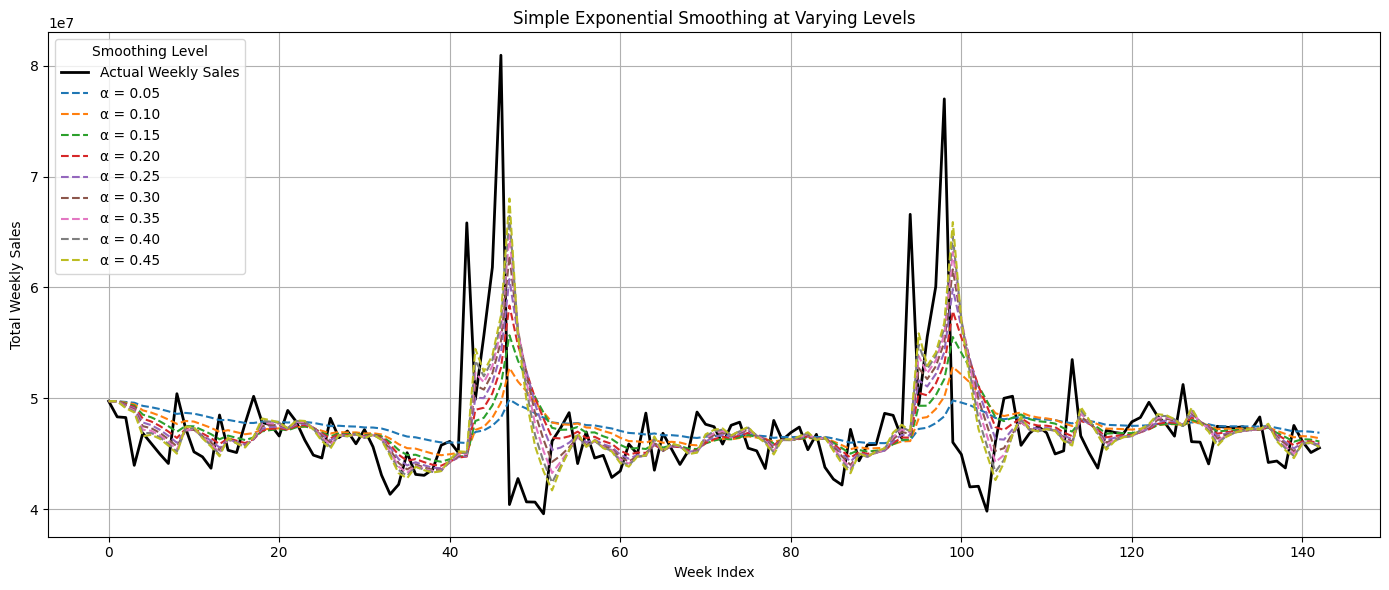

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
# Define smoothing levels
smoothing_levels = np.arange(0.05, 0.5, 0.05)

# Initialize plot
plt.figure(figsize=(14, 6))

# Plot actual weekly sales
plt.plot(
    aggregated_data['total_weekly_sales'].values,
    label='Actual Weekly Sales',
    color='black',
    linewidth=2
)
model = SimpleExpSmoothing(aggregated_data['total_weekly_sales'])
# Fit and plot smoothed lines
for alpha in smoothing_levels:
    fitted_model = model.fit(smoothing_level=alpha, optimized=False)
    smoothed = fitted_model.fittedvalues
    plt.plot(smoothed, label=f'α = {alpha:.2f}', linestyle='--')

# Formatting
plt.title('Simple Exponential Smoothing at Varying Levels')
plt.xlabel('Week Index')
plt.ylabel('Total Weekly Sales')
plt.legend(title="Smoothing Level", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


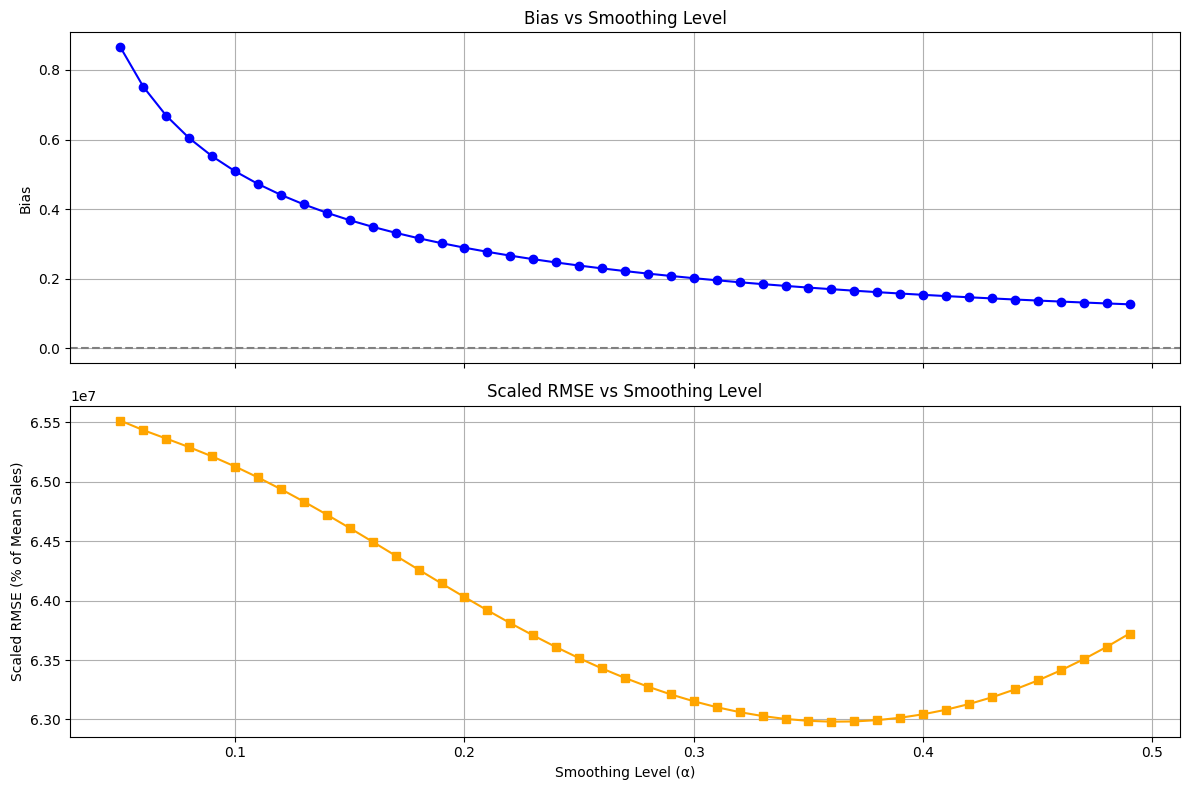

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_squared_error

# Mean of actual weekly sales
mean_sales = aggregated_data['total_weekly_sales'].mean()

# Store results
bias_results = {}
scaled_rmse_results = {}

# Loop through smoothing levels
for i in np.arange(0.05, 0.5, 0.01):
    model = SimpleExpSmoothing(aggregated_data['total_weekly_sales'])
    fitted_model = model.fit(smoothing_level=i, optimized=False)

    smoothed = fitted_model.fittedvalues
    error = smoothed - aggregated_data['total_weekly_sales']

    bias = error.mean()/mean_sales * 100
    rmse = mean_squared_error(aggregated_data['total_weekly_sales'], smoothed)
    scaled_rmse = rmse / mean_sales * 100  # in %

    alpha = round(i, 2)
    bias_results[alpha] = bias
    scaled_rmse_results[alpha] = scaled_rmse

# Prepare data
alphas = list(bias_results.keys())
biases = list(bias_results.values())
scaled_rmses = list(scaled_rmse_results.values())

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot Bias
axes[0].plot(alphas, biases, marker='o', color='blue')
axes[0].axhline(0, color='gray', linestyle='--')
axes[0].set_title('Bias vs Smoothing Level')
axes[0].set_ylabel('Bias')
axes[0].grid(True)

# Plot Scaled RMSE
axes[1].plot(alphas, scaled_rmses, marker='s', color='orange')
axes[1].set_title('Scaled RMSE vs Smoothing Level')
axes[1].set_ylabel('Scaled RMSE (% of Mean Sales)')
axes[1].set_xlabel('Smoothing Level (α)')
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [17]:
combined_error = {
    key: abs(bias_results[key]) + scaled_rmse_results[key]
    for key in bias_results
}

# Find the key with the minimum combined error
best_key = min(combined_error, key=combined_error.get)

# Return the best parameters and their metrics
print(f"Best smoothing parameters: {best_key}")


Best smoothing parameters: 0.36


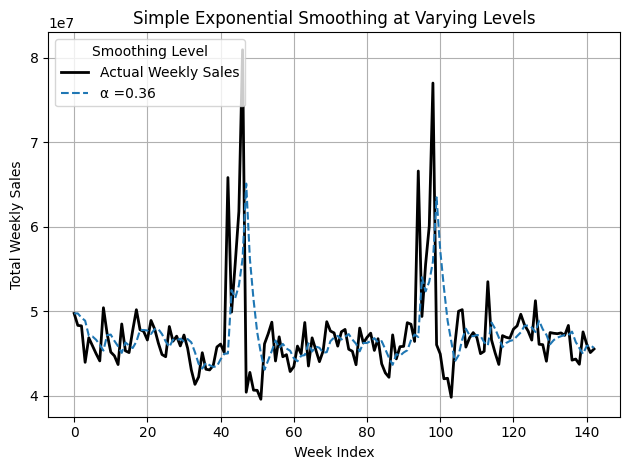

In [18]:
plt.plot(
    aggregated_data['total_weekly_sales'].values,
    label='Actual Weekly Sales',
    color='black',
    linewidth=2
)
model = SimpleExpSmoothing(aggregated_data['total_weekly_sales'])

fitted_model = model.fit(smoothing_level=0.36, optimized=False)
smoothed = fitted_model.fittedvalues

plt.plot(smoothed, label=f'α =0.36', linestyle='--')

# Formatting
plt.title('Simple Exponential Smoothing at Varying Levels')
plt.xlabel('Week Index')
plt.ylabel('Total Weekly Sales')
plt.legend(title="Smoothing Level", loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### Double Smoothing

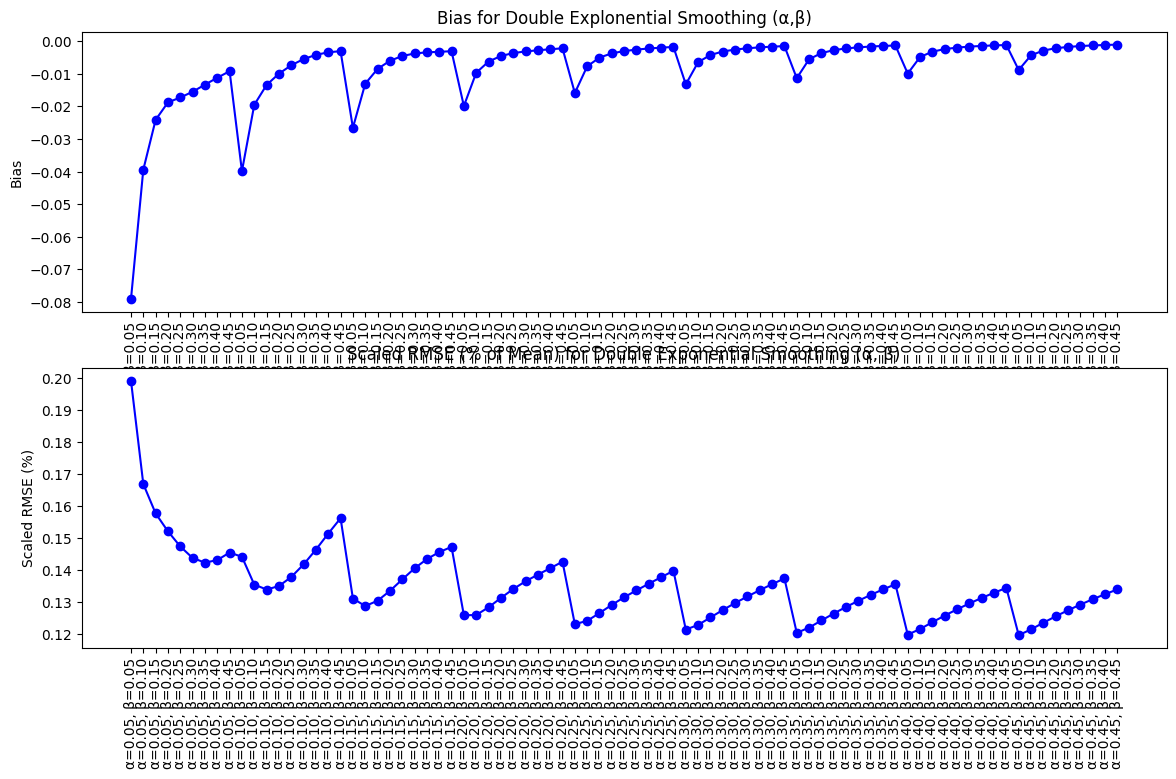

In [19]:
from statsmodels.tsa.holtwinters import Holt

import matplotlib.pyplot as plt

bias_results ={}
scaled_rmse_results ={}
mean_sales = aggregated_data['total_weekly_sales'].mean()
for alpha in np.arange(0.05, 0.5, 0.05):
    for beta in np.arange(0.05, 0.5, 0.05):
        model= Holt(aggregated_data['total_weekly_sales'])
        fitted_model =model.fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
        smoothed= fitted_model.fittedvalues
        error = smoothed - aggregated_data['total_weekly_sales']
        bias = error.mean()/mean_sales
        scaled_rmse = np.sqrt((error **2).mean())/mean_sales
        key = f'α={alpha:.2f}, β={beta:.2f}'
        bias_results[key] =bias
        scaled_rmse_results[key] =scaled_rmse
keys = list(bias_results.keys())
biases = [bias_results[k] for k in keys]
rmses = [scaled_rmse_results[k] for k in keys]


fig, axes =plt.subplots(2,1,figsize=(14,8), sharex=False)

axes[0].plot(keys, biases, marker='o', color='blue')
axes[0].set_title('Bias for Double Explonential Smoothing (α,β)')
axes[0].set_ylabel('Bias')
axes[0].tick_params(axis='x', rotation=90)


axes[1].plot(keys, rmses, marker='o', color='blue')
axes[1].set_title('Scaled RMSE (% of Mean) for Double Exponential Smoothing (α, β)')
axes[1].set_ylabel('Scaled RMSE (%)')
axes[1].tick_params(axis='x', rotation=90)


In [20]:
aggregated_data.dtypes

Year                   UInt32
WW                     UInt32
total_weekly_sales    float64
moving_avg_2          float64
moving_avg_6          float64
moving_avg_12         float64
moving_avg_18         float64
Error                 float64
dtype: object

The RMSE and the Bias values are fluctuating and thus I will move to the next model to get a better results

### DoubleSmoothingwith DampedTrend

Optimized α: 0.3562
Optimized β: 0.0000
Optimized damping ϕ: 0.8000


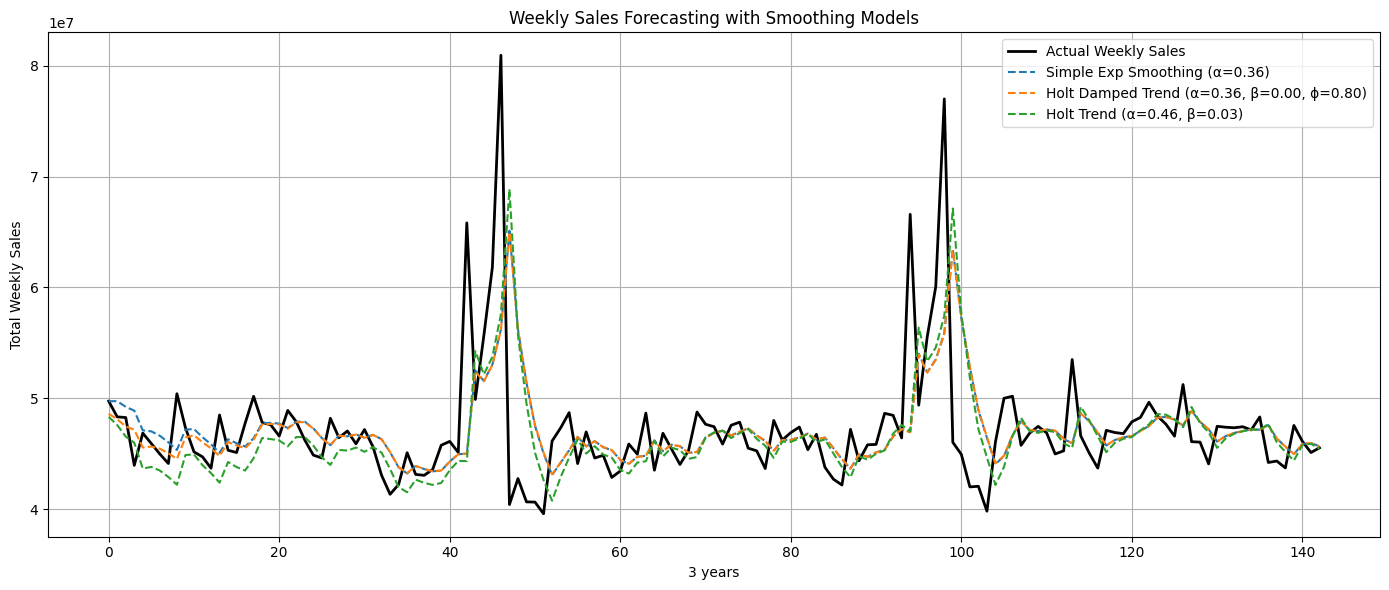

In [21]:
from statsmodels.tsa.holtwinters import Holt, SimpleExpSmoothing
import matplotlib.pyplot as plt
# Holt’s Linear Trend model with optimized alpha, beta
model_z = Holt(aggregated_data['total_weekly_sales'])
fitted_model_c = model_z.fit(optimized=True)
smoothed_c = fitted_model_c.fittedvalues

# Extract optimized parameters
alpha_a = fitted_model_c.params.get('smoothing_level')
beta_a= fitted_model_c.params.get('smoothing_trend')


# Holt’s Linear Trend model with optimized alpha, beta, and damping
model_x = Holt(aggregated_data['total_weekly_sales'], damped_trend=True)
fitted_model_d = model_x.fit(optimized=True)
smoothed_d = fitted_model_d.fittedvalues

# Extract optimized parameters
alpha = fitted_model_d.params.get('smoothing_level')
beta = fitted_model_d.params.get('smoothing_trend')
damping = fitted_model_d.params.get('damping_trend')

print(f"Optimized α: {alpha:.4f}")
print(f"Optimized β: {beta:.4f}")
if damping is not None:
    print(f"Optimized damping ϕ: {damping:.4f}")

# Simple exponential smoothing with fixed alpha = 0.36
model_y = SimpleExpSmoothing(aggregated_data['total_weekly_sales'])
fitted_model_s = model_y.fit(smoothing_level=0.36, optimized=False)
smoothed_s = fitted_model_s.fittedvalues

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(aggregated_data['total_weekly_sales'].values, label='Actual Weekly Sales', color='black', linewidth=2)
plt.plot(smoothed_s, label='Simple Exp Smoothing (α=0.36)', linestyle='--')
plt.plot(smoothed_d, label=f'Holt Damped Trend (α={alpha:.2f}, β={beta:.2f}, ϕ={damping:.2f})', linestyle='--')
plt.plot(smoothed_c, label=f'Holt Trend (α={alpha_a:.2f}, β={beta_a:.2f})', linestyle='--')
# Formatting
plt.title('Weekly Sales Forecasting with Smoothing Models')
plt.xlabel('3 years')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



We see that all three models are approximaetely giving similar value of alpha and we don't have a beta value which indicates a lack of trend
after optimization, the dampening factor can be used to soften the outliers but not much effect can be seen in this case

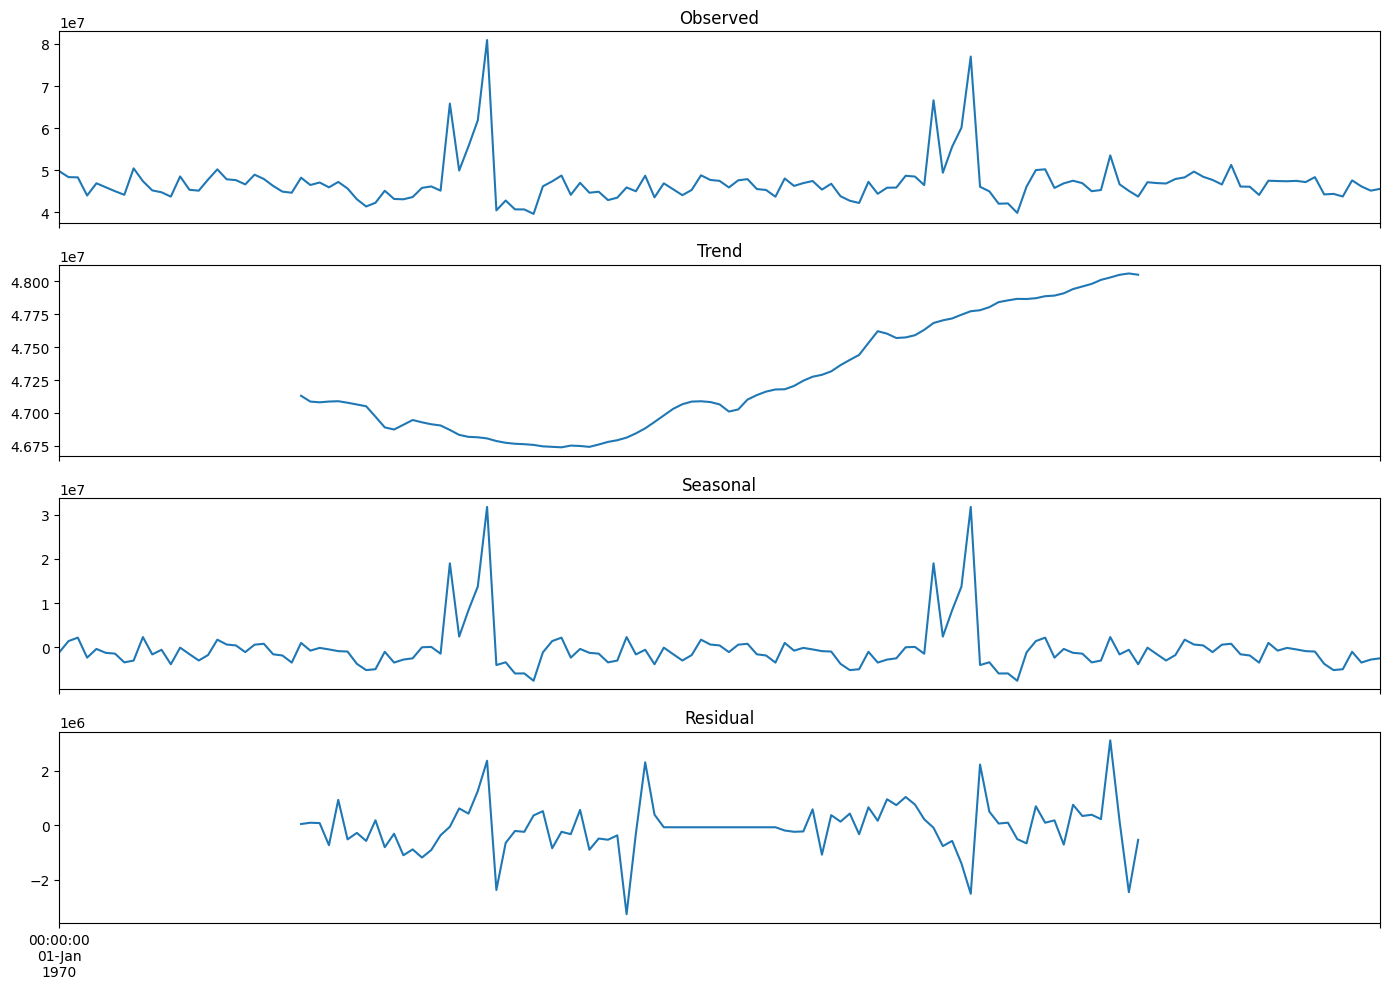

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
aggregated_data = aggregated_data.copy()
aggregated_data.index =pd.to_datetime(aggregated_data.index)
decomposition = seasonal_decompose(aggregated_data['total_weekly_sales'],
                                model='additive', period=52)
fig,axes =plt.subplots(4,1, figsize=(14,10), sharex=True)
decomposition.observed.plot(ax=axes[0], title ='Observed')
decomposition.trend.plot(ax=axes[1], title='Trend')
decomposition.seasonal.plot(ax=axes[2], title ='Seasonal')
decomposition.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


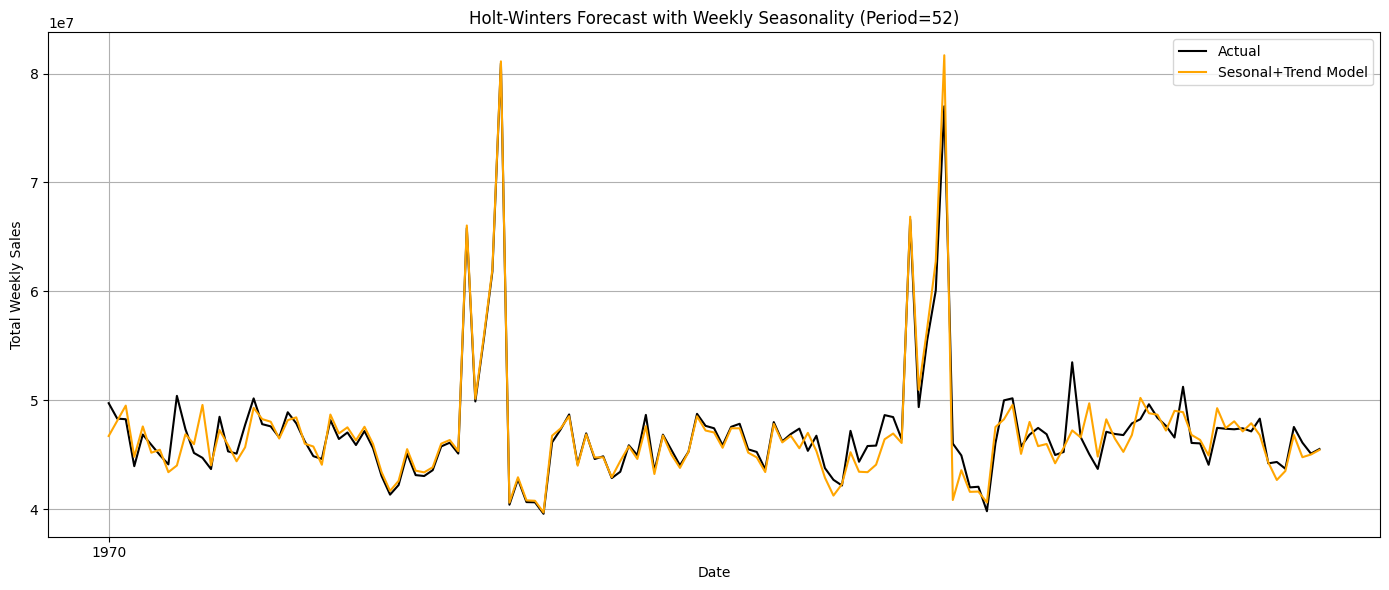

Optimized alpha (level):   0.0715
Optimized beta (trend):   0.0179
Optimized gamma (season): 0.1640
Optimized phi (damping):  nan


In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(
    aggregated_data['total_weekly_sales'],
    trend='add',
    seasonal='add',  
    seasonal_periods=52,
    initialization_method='estimated'
)

fitted_model = model.fit(optimized=True)

plt.figure(figsize=(14,6))
plt.plot(aggregated_data['total_weekly_sales'], label='Actual', color='black')
plt.plot(fitted_model.fittedvalues, label='Sesonal+Trend Model', color ="orange")
plt.title('Holt-Winters Forecast with Weekly Seasonality (Period=52)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

params = fitted_model.params

alpha = params.get('smoothing_level')
beta = params.get('smoothing_trend')
gamma = params.get('smoothing_seasonal')
phi = params.get('damping_trend')

print(f"Optimized alpha (level):   {alpha:.4f}")
print(f"Optimized beta (trend):   {beta:.4f}")
print(f"Optimized gamma (season): {gamma:.4f}")
print(f"Optimized phi (damping):  {phi:.4f}")

### Finding Outliers

In [24]:
lower = aggregated_data['total_weekly_sales'].quantile(0.05)
upper = aggregated_data['total_weekly_sales'].quantile(0.95)

aggregated_data['winsorized_data'] = aggregated_data['total_weekly_sales'].clip(lower, upper)
mean = aggregated_data['total_weekly_sales'].mean()
std =aggregated_data['total_weekly_sales'].std()

lower =mean-3*std
upper =mean+3*std
aggregated_data['std_clipped_data'] =aggregated_data['total_weekly_sales'].clip(lower,upper)

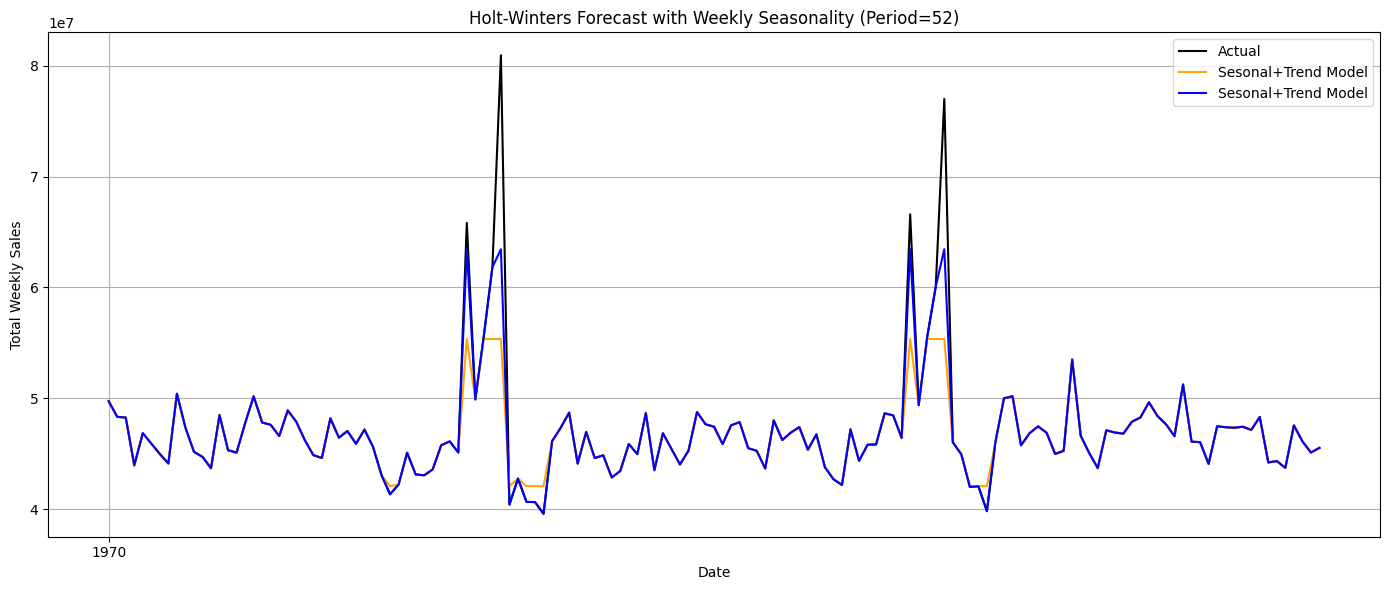

In [25]:
plt.figure(figsize=(14,6))
plt.plot(aggregated_data['total_weekly_sales'], label='Actual', color='black')
plt.plot(aggregated_data['winsorized_data'], label='Sesonal+Trend Model', color ="orange")
plt.plot(aggregated_data['std_clipped_data'], label='Sesonal+Trend Model', color ="blue")
plt.title('Holt-Winters Forecast with Weekly Seasonality (Period=52)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

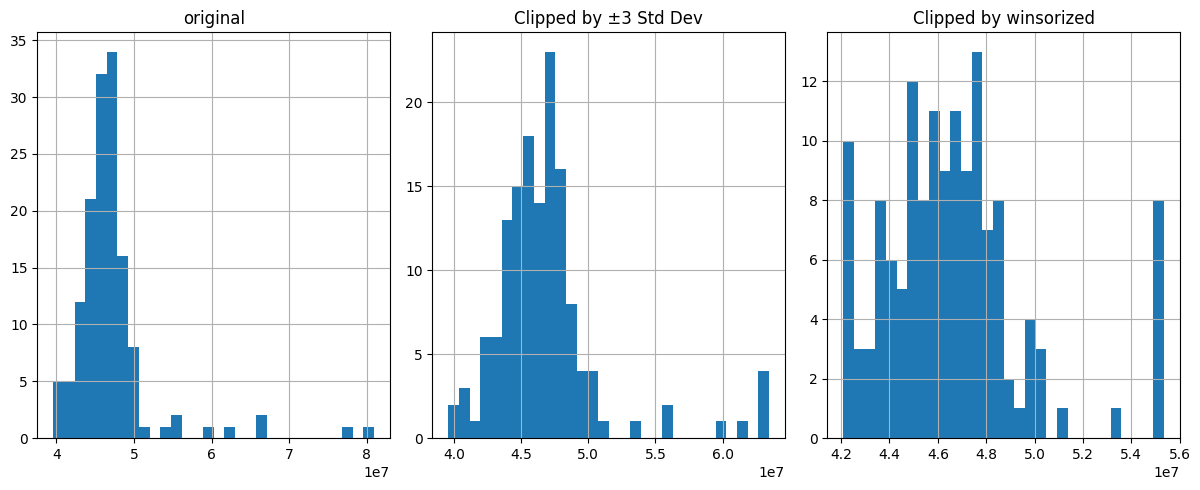

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
aggregated_data["total_weekly_sales"].hist(bins=30)
plt.title("original")
plt.subplot(1,3,2)
aggregated_data['std_clipped_data'].hist(bins=30)
plt.title("Clipped by ±3 Std Dev")

plt.subplot(1,3,3)
aggregated_data['winsorized_data'].hist(bins=30)
plt.title("Clipped by winsorized")
plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ns will be used.
  self._init_dates(dates, freq)


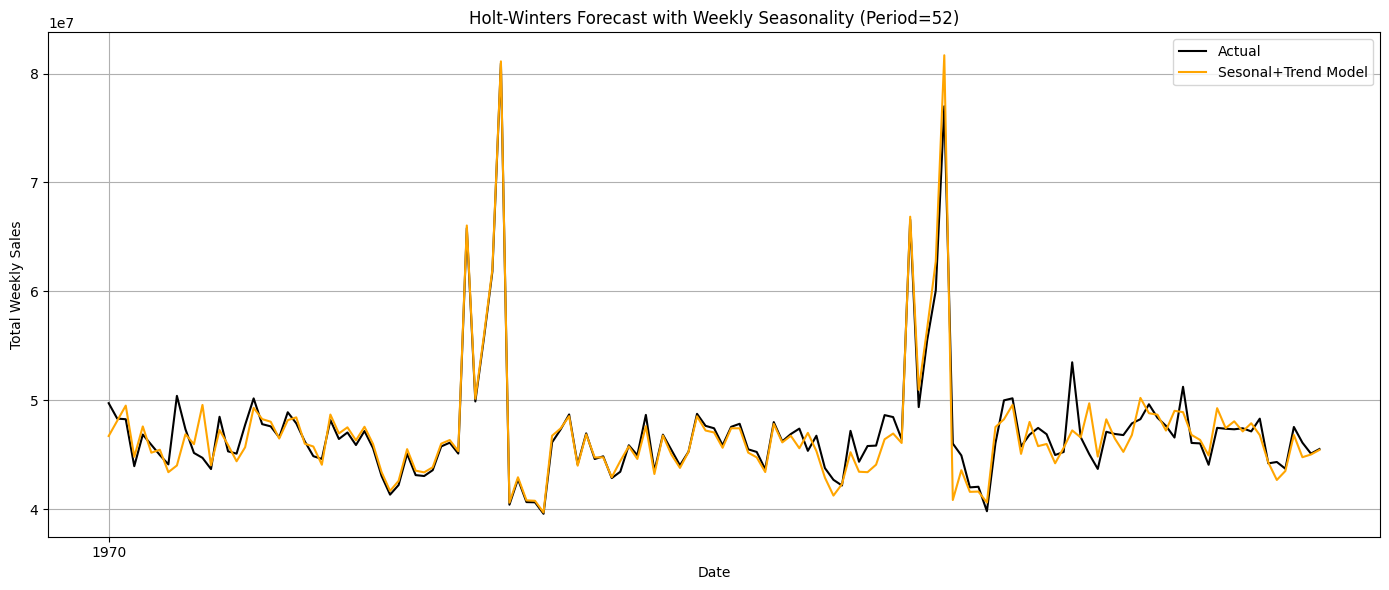

Optimized alpha (level):   0.0715
Optimized beta (trend):   0.0179
Optimized gamma (season): 0.1640
Optimized phi (damping):  nan


In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(
    aggregated_data['total_weekly_sales'],
    trend='add',
    seasonal='add',  
    seasonal_periods=52,
    initialization_method='estimated'
)

fitted_model = model.fit(optimized=True)

plt.figure(figsize=(14,6))
plt.plot(aggregated_data['total_weekly_sales'], label='Actual', color='black')
plt.plot(fitted_model.fittedvalues, label='Sesonal+Trend Model', color ="orange")
plt.title('Holt-Winters Forecast with Weekly Seasonality (Period=52)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

params = fitted_model.params

alpha = params.get('smoothing_level')
beta = params.get('smoothing_trend')
gamma = params.get('smoothing_seasonal')
phi = params.get('damping_trend')

print(f"Optimized alpha (level):   {alpha:.4f}")
print(f"Optimized beta (trend):   {beta:.4f}")
print(f"Optimized gamma (season): {gamma:.4f}")
print(f"Optimized phi (damping):  {phi:.4f}")